# MOM6 ANALYSIS - Overview Plot
The key purpose of this notebook will be to create an overview plot of the Study region.
I'd like this overview plot to be a simple, clear picture of the nesting approach, as well as baseline picture of the EAC dynamics and flow fields. 

**Adjusted for paper** - 29th April 2024
The steps to reproduce the figure are:
1. Load in velocity (u/v) data from ACCESS-OM2-01, STHPAC-01, EAC-003 (the latter two being the large and small regional models respectively).
2. Decide on a depth level for the plot - From memory I chose somewhere around 50m to show the ocean features rather than atmospheric imprint on the surface.
3. Do some spatial subsetting, regridding and calculate speed from the regridded u/v data fields.
4. Plot the nested fields. 

In [1]:
import matplotlib.pyplot as plt
import cmocean as cm
import xarray as xr
import numpy as np
import glob
import xesmf

In [2]:
from xgcm import Grid

from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')

In [3]:
# import cartopy to plot maps
import cartopy.crs as ccrs
import cartopy.feature as feature
land_50m = feature.NaturalEarthFeature('physical', 'land', '50m', 
                                       edgecolor='black',
                                       facecolor='gray',
                                       linewidth=0.2)
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41727,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:39839,Total threads: 4
Dashboard: /proxy/43085/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:45409,


In [5]:
# set paths to model output
## SRM
eac_003 = '/scratch/v45/jr5971/mom6-setonix/eac_iaf_003/'
## LRM
sthpac_01 = '/scratch/v45/jr5971/mom6-setonix/sthpac_iaf_01/'
## PARENT
access = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/'

### Load OM2 data

In [6]:
year_month = '1992_12'
# access velocities
om2_u_path = glob.glob(access + f'output*/ocean/*u*{year_month}*.nc')
om2_v_path = glob.glob(access + f'output*/ocean/*v*{year_month}*.nc')
om2_u = xr.open_dataset(om2_u_path[0])['u']
om2_v = xr.open_dataset(om2_v_path[0])['v']

om2_vel = xr.merge([om2_u, om2_v])
om2_vel

0.3.0


<xarray.Dataset>
Dimensions:   (xu_ocean: 3600, yu_ocean: 2700, st_ocean: 75, time: 31)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 1992-12-01T12:00:00 ... 1992-12-31T12:00:00
Data variables:
    u         (time, st_ocean, yu_ocean, xu_ocean) float32 ...
    v         (time, st_ocean, yu_ocean, xu_ocean) float32 ...
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity

### Get MOM6 data

In [7]:
%%time
year_month = '199212'

# eac vels
eac_u_path = glob.glob(eac_003 + f'output*/{year_month}*u_3d*nc')[0]
eac_v_path = glob.glob(eac_003 + f'output*/{year_month}*v_3d*nc')[0]
eac_u = xr.open_dataset(eac_u_path)['uo']
eac_v = xr.open_dataset(eac_v_path)['vo']

eac = xr.merge([eac_u, eac_v])

# sthpac vels
sthpac_u_path = glob.glob(sthpac_01 + f'output*/{year_month}*u_3d.nc')[0]
sthpac_v_path = glob.glob(sthpac_01 + f'output*/{year_month}*v_3d.nc')[0]
sthpac_u = xr.open_dataset(sthpac_u_path)['uo']
sthpac_v = xr.open_dataset(sthpac_v_path)['vo']

sthpac = xr.merge([sthpac_u, sthpac_v])

CPU times: user 186 ms, sys: 211 ms, total: 396 ms
Wall time: 574 ms


## Choose spatial and temporal extent
In order to make the regridding quicker later on, let's choose a temporal extent now. 

In [8]:
# Choose depth
depth_level = 5 # m

om2_2d = om2_vel.sel(st_ocean=depth_level, method='nearest')
sthpac_2d = sthpac.sel(z_l=depth_level, method='nearest')
eac_2d = eac.sel(z_l=depth_level, method='nearest')

### Make Grids Symmetric

In [9]:
# EAC
# bottom corner "centre" coord
print('Bottom left centre points: ', np.round(eac.xh.min().values, 2), np.round(eac.yh.min().values,2))
# bottom left "corner" coord...
print('Bottom left CORNER points: ', np.round(eac.xq.min().values, 2), np.round(eac.yq.min().values,2))

Bottom left centre points:  -217.78 -46.18
Bottom left CORNER points:  -217.8 -46.19


In [10]:
# CREATE SYMMETRIC DATASETS
eac_symmetric = eac_2d.isel(xq=slice(1,len(eac.xq)), yq = slice(1,len(eac.yq)))
sthpac_symmetric = sthpac_2d.isel(xq=slice(1,len(sthpac.xq)), yq=slice(1,len(sthpac.yq)))

In [11]:
# EAC
# bottom corner "centre" coord
print('Bottom left centre points: ', np.round(eac_symmetric.xh.min().values, 2), np.round(eac_symmetric.yh.min().values,2))
# bottom left "corner" coord...
print('Bottom left CORNER points: ', np.round(eac_symmetric.xq.min().values, 2), np.round(eac_symmetric.yq.min().values,2))

Bottom left centre points:  -217.78 -46.18
Bottom left CORNER points:  -217.77 -46.17


In [12]:
# get grid cell thickness data
eac_static = xr.open_dataset(eac_003 + 'output000/19900202.ocean_static.nc')
sthpac_static = xr.open_dataset(sthpac_01 + 'output000/19900201.ocean_static.nc')

eac_symmetric['dxt'] = eac_static['dxt']
eac_symmetric['dyt'] = eac_static['dyt']
sthpac_symmetric['dxt'] = sthpac_static['dxt']
sthpac_symmetric['dyt'] = sthpac_static['dyt']


# Define new aligned grids
metrics = { 
    ('X',) : ['dxt'], # X distances
    ('Y',) : ['dyt'] # Y  distances
}
coords = {'X' : {'center':'xh', 'right':'xq'},
          'Y' : {'center':'yh', 'right':'yq'} }

eac_grid = Grid(eac_symmetric, coords=coords, metrics=metrics, periodic=False)
sthpac_grid = Grid(sthpac_symmetric, coords=coords, metrics=metrics, periodic=False)
eac_grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   xh --> right
  * right    xq --> center
Y Axis (not periodic, boundary=None):
  * center   yh --> right
  * right    yq --> center

Overwrite the meridional velocities (`vo`) in the symmetric datasets with the new offset points

In [13]:
%%time
eac_symmetric['vo'] = eac_grid.interp(eac_symmetric['vo'], axis=['X','Y'])
sthpac_symmetric['vo'] = sthpac_grid.interp(sthpac_symmetric['vo'], axis=['X','Y'])
print(eac_symmetric['vo'].dims, eac['vo'].dims)

('time', 'yh', 'xq') ('time', 'z_l', 'yq', 'xh')
CPU times: user 320 ms, sys: 887 ms, total: 1.21 s
Wall time: 1.08 s


### Subset ACCESS spatially

In [14]:
# subset global to some region just bigger than the sthpac model...
sthpac_idx = {'W':sthpac.xh.min().values, 'E':sthpac.xh.max().values, 
              'S':sthpac.yh.min().values, 'N':sthpac.yh.max().values}
eac_idx = {'W':eac.xh.min().values, 'E':eac.xh.max().values,
           'S':eac.yh.min().values, 'N':eac.yh.max().values}
om2_subset = om2_2d.sel(xu_ocean=slice(sthpac_idx['W'] - 30, sthpac_idx['E']+50),
                                          yu_ocean = slice(sthpac_idx['S']-30, sthpac_idx['N']+30))

# Plotting

In [15]:
from matplotlib import patches
import cartopy.feature as cfeature
import matplotlib.lines as mlines
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [16]:
%%time
sthpac_2d_snap = sthpac_symmetric.load()
eac_2d_snap = eac_symmetric.load()

CPU times: user 196 ms, sys: 795 ms, total: 991 ms
Wall time: 894 ms


In [17]:
sthpac_speed = np.sqrt(sthpac_2d_snap['vo']**2 + sthpac_2d_snap['uo']**2).compute()
eac_speed = np.sqrt(eac_2d_snap['vo']**2 + eac_2d_snap['uo']**2).compute()

In [18]:
%%time
# Choose single day to calculate speed for all variables. 
day = '1992-12-22'
om2_2d_snap = om2_subset.sel(time=day)
sthpac_2d_snap = sthpac_speed.sel(time=day)
eac_2d_snap = eac_speed.sel(time=day)

# Calculate snapshot of speed
om2_speed = np.sqrt(om2_2d_snap['v']**2 + om2_2d_snap['u']**2).compute()

CPU times: user 1.09 s, sys: 87.8 ms, total: 1.17 s
Wall time: 1.06 s


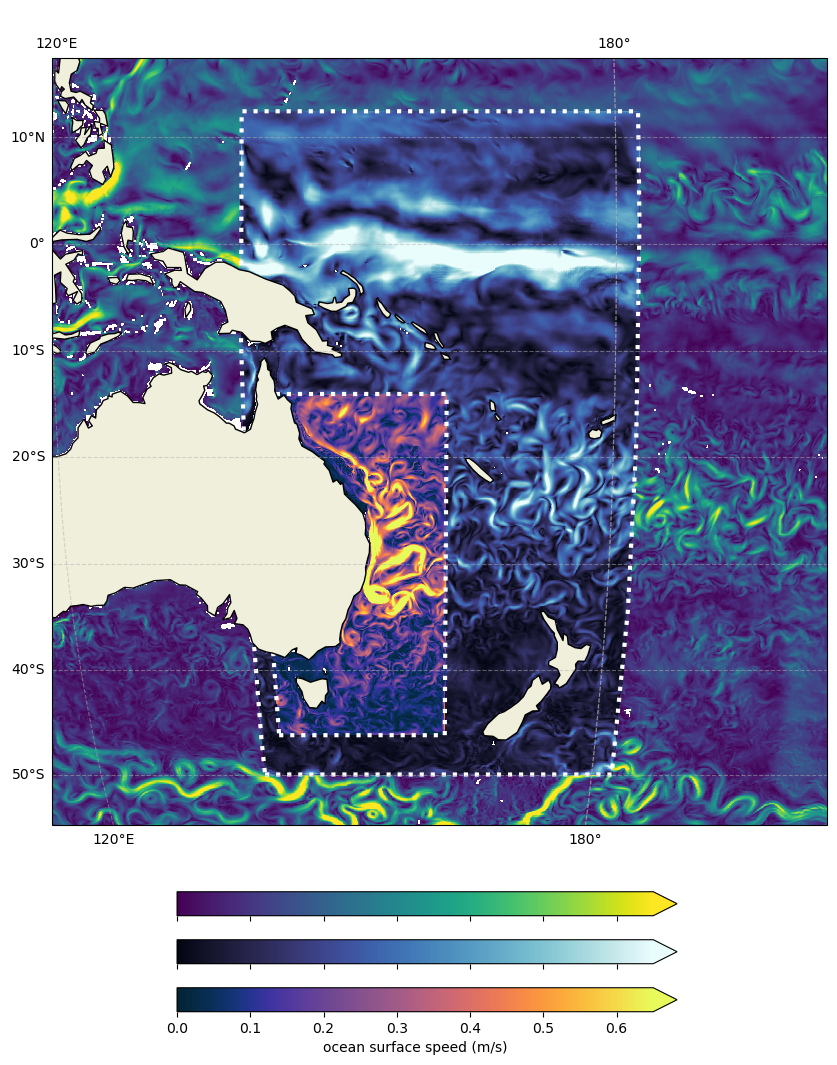

In [38]:
fig = plt.figure(figsize=(10, 12))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-200))

vmax = 0.65

# Plot access
h1 = om2_speed.plot(ax=ax,
               vmin=0, vmax=vmax,
               transform=ccrs.PlateCarree(), zorder=0, alpha=1, add_colorbar=False, rasterized=True)
h2 = sthpac_2d_snap.plot(ax=ax,
                    vmin=0, vmax=vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cm.cm.ice, add_colorbar=False, rasterized=True)
h3 = eac_2d_snap.plot(ax=ax,
                 vmin=0, vmax=vmax,
                 transform=ccrs.PlateCarree(),
                 cmap=cm.cm.thermal, add_colorbar=False, rasterized=True)

box1 = patches.Rectangle((sthpac_idx['W'], sthpac_idx['S']), (sthpac_idx['E']-sthpac_idx['W']), 
                        (sthpac_idx['N']-sthpac_idx['S']), color='w', fill=None, transform=ccrs.PlateCarree(),
                        alpha=1, linestyle=':', linewidth=3)
box2 = patches.Rectangle((eac_idx['W'], eac_idx['S']), (eac_idx['E']-eac_idx['W']), 
                        (eac_idx['N']-eac_idx['S']), color='w', fill=None, transform=ccrs.PlateCarree(),
                        alpha=1, linestyle=':', linewidth=3)

# Add a colorbar axis at the bottom of the graph
cbar_ax1 = fig.add_axes([0.25, 0.10, 0.5, 0.02])
cbar_ax2 = fig.add_axes([0.25, 0.06, 0.5, 0.02])
cbar_ax3 = fig.add_axes([0.25, 0.02, 0.5, 0.02])

# Draw the colorbar
cbar1=fig.colorbar(h1, shrink=0.45, cax=cbar_ax1, orientation='horizontal', extend='max')
cbar2=fig.colorbar(h2, shrink=0.45, cax=cbar_ax2, orientation='horizontal', extend='max')
cbar3=fig.colorbar(h3, shrink=0.45, cax=cbar_ax3, orientation='horizontal', label='ocean surface speed (m/s)', extend='max')

cbar1.ax.set_xticklabels(["", "", "", "", "", "", ""])
cbar2.ax.set_xticklabels(["", "", "", "", "", "", ""])

ax.add_patch(box1); ax.add_patch(box2)

ax.add_feature(cfeature.LAND, zorder=0)
ax.add_feature(cfeature.LAND, zorder=1)
    
# Set custom ticks on x and y axes
# ax.set_xticks((120, 140), crs=ccrs.PlateCarree())
# ax.set_yticks(yticks, crs=ccrs.PlateCarree());

extent = [sthpac_idx['W']-20, sthpac_idx['E']+20, sthpac_idx['S']-5, sthpac_idx['N']+5]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.coastlines()

ax.set_title(' ', fontsize=18)

# # Add latitude and longitude labels to the ticks
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')

fig.savefig('nested-regional-mom6.pdf', bbox_inches='tight')